# Harris County Home Price Estimations


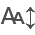

In [56]:
import os
import sqlite3
from datetime import datetime

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from itables import init_notebook_mode, show
from matplotlib import pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from load_to_dataframe import load_data_frame

init_notebook_mode(all_interactive=True)

# Load Data From SQLite Database
In the file load_to_dataframe.py there is a function that will connect to the database and run a query that will join 4 files on the building_res table and do much of the data preprocessing and some filter of data.
* Only houses with improvement type 1001 (single family homes) will be selected
* The date erected must be greater than 1900
* The assessed value must be greater than 0
* the square footage must be greater than 50

In [2]:
df = load_data_frame()

# Haversine Function
The haversine function is used to calculate the distance between two sets of latitude and longitude coordinates. In this case one of the fixed points is the center of downtown Houston (29.760100, -95.370100). The assumption is, the closer to Houston's downtown, the higher the value.

In [3]:
# Define the haversine function
def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in miles
    r = 3958.8
    # Convert degrees to radians
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_phi = np.radians(lat2 - lat1)
    d_lambda = np.radians(lon2 - lon1)
    # Haversine formula
    a = np.sin(d_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return r * c


# Define the single point (latitude, longitude) to calculate the distance from
single_point = (29.760100, -95.370100)  # Houston

# Add a new column with distances
df["distance_miles"] = df.apply(
    lambda row: haversine(single_point[0], single_point[1], row["latitude"], row["longitude"]),
    axis=1,
)

# Price Per Square Foot
This is another metric that I will explor to see if there is a relationship between other values.

In [4]:
df["assessed_per_sqft"] = df["assessed_per_sqft"].replace([np.inf, -np.inf], np.nan)

In [5]:
df["assessed_per_sqft"].describe()

count    1.115156e+06
mean     1.824132e+02
std      3.866353e+02
min      1.785714e+00
25%      1.248015e+02
50%      1.440565e+02
75%      1.728197e+02
max      3.432030e+04
Name: assessed_per_sqft, dtype: float64

# Reduce data set to manageable size
The current data set is over 1.1M rows. This will take days to train a model on a regular computer. 

The help reduce the dataset I will start by removing all homes where the im_sq_ft is less than 50, since it is not really livable when there are not even 50 square feet of space.

The dataset will be reduced even more to only include homes that are assessed less than or equal to 2 million dollars.


In [6]:
df.shape

(1115156, 32)

In [7]:
df = df[df["assessed_val"] <= 2000000]

In [8]:
y_market = df["tot_mkt_val"]
y = df["assessed_val"]
y_bld_val = df["bld_val"]
y_per_sqft = df["assessed_per_sqft"]

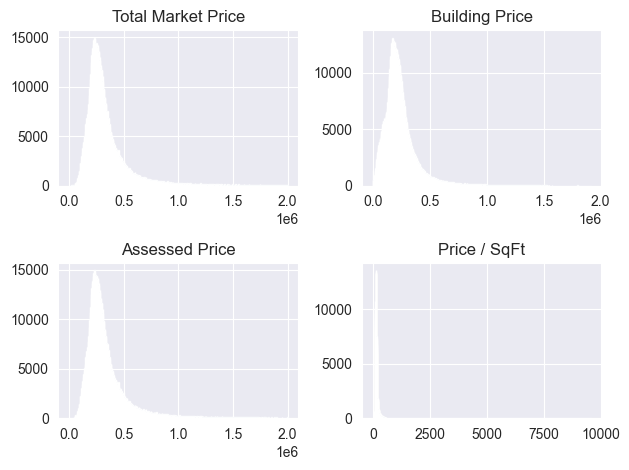

In [9]:
fig, axs = plt.subplots(2, 2)

# Total Market Price
axs[0, 0].hist(y_market, bins="auto")
axs[0, 0].set_title("Total Market Price")

# Assessed values
axs[1, 0].hist(y, bins="auto")
axs[1, 0].set_title("Assessed Price")

# Building value
axs[0, 1].hist(y_bld_val, bins="auto")
axs[0, 1].set_title("Building Price")

# Price per square foot
axs[1, 1].hist(y_per_sqft, bins="auto")
axs[1, 1].set_title("Price / SqFt")

fig.tight_layout()
plt.show()

In [10]:
# # IQR
# Q1 = df["assessed_val"].quantile(0.25)
# Q3 = df["assessed_val"].quantile(0.75)
# IQR = Q3 - Q1

# lower_iqr = Q1 - 1.5 * IQR
# upper_iqr = Q3 + 1.5 * IQR
# print(f"Lower IQR: {lower_iqr} | Upper IQR: {upper_iqr}")

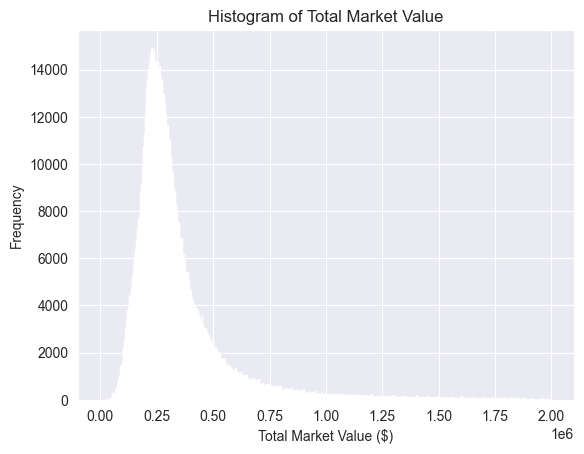

In [11]:
plt.hist(df["tot_mkt_val"], bins="auto")
plt.xlabel("Total Market Value ($)")
plt.ylabel("Frequency")
plt.title("Histogram of Total Market Value")
plt.show()

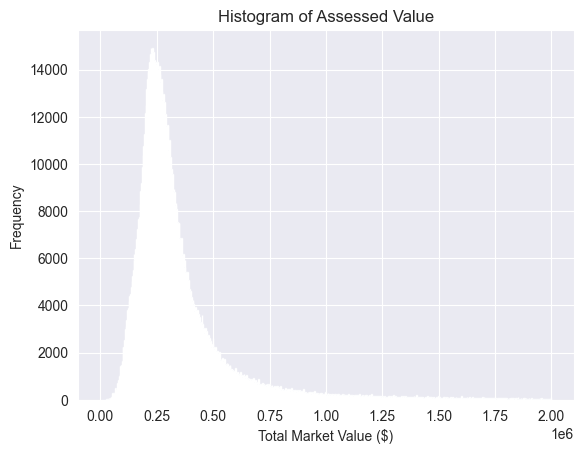

In [12]:
plt.hist(df["assessed_val"], bins="auto")
plt.xlabel("Total Market Value ($)")
plt.ylabel("Frequency")
plt.title("Histogram of Assessed Value")
plt.show()

## Sample Size Reduction
Since the data set is still over 1M homes, we need to reduce the size to create a model.

In [13]:
sample_df = df.sample(n=5000, random_state=42)
show(sample_df)

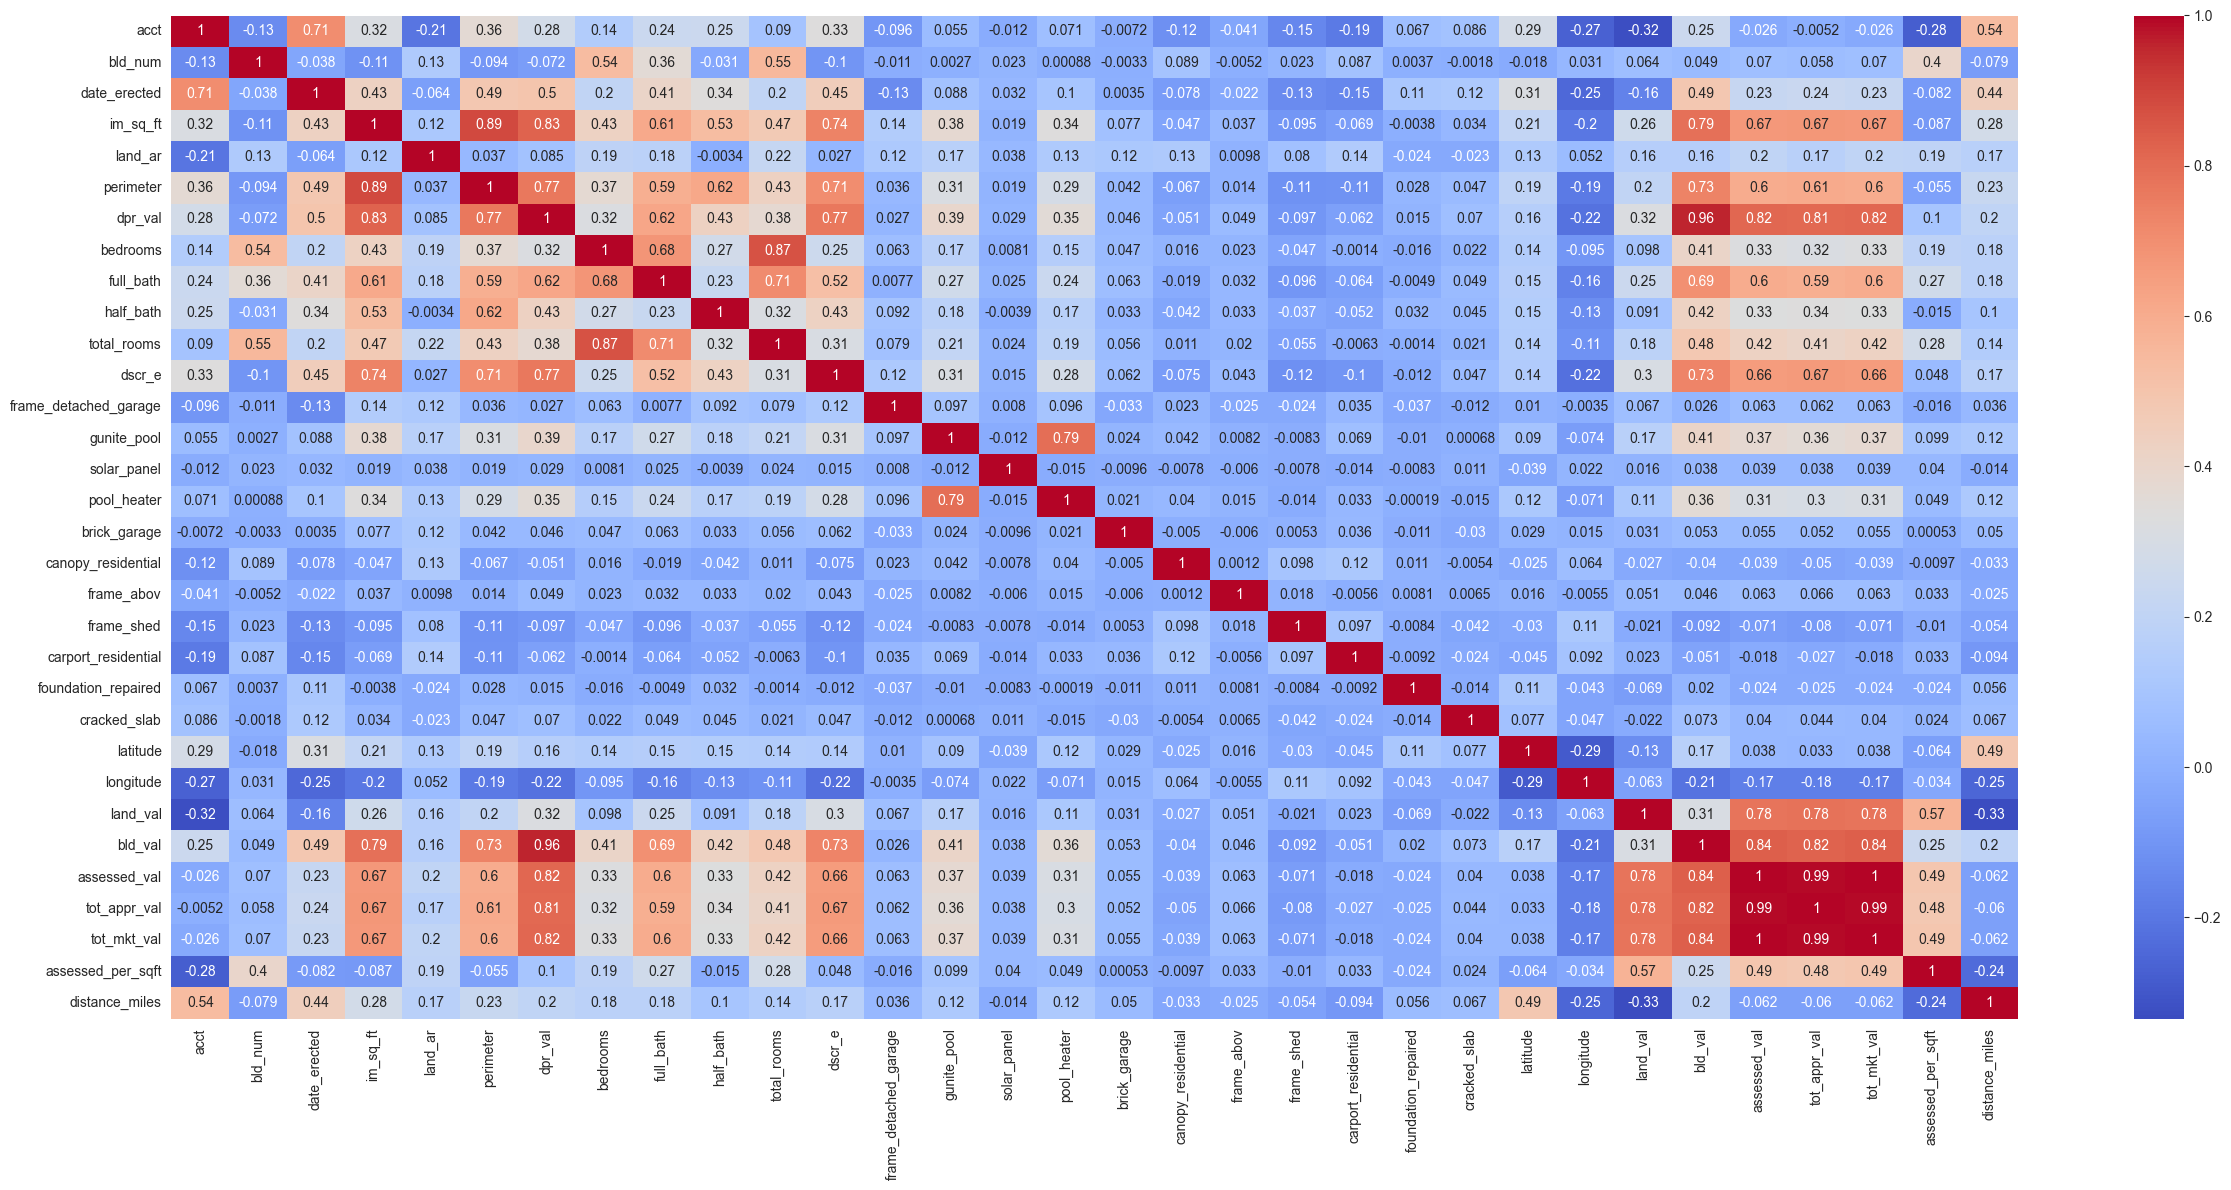

In [14]:
corr_matrix = sample_df.corr()
plt.figure(figsize=(25, 12))
sns.heatmap(data=corr_matrix, annot=True, cmap="coolwarm")
plt.tight_layout()
plt.show()

In [15]:
X = sample_df[
    [
        "date_erected",
        "im_sq_ft",
        "land_ar",
        "perimeter",
        "bedrooms",
        "full_bath",
        "half_bath",
        "total_rooms",
        "latitude",
        "longitude",
        "dscr_e",
        "frame_detached_garage",
        "gunite_pool",
        "pool_heater",
        "brick_garage",
        "canopy_residential",
        "frame_abov",
        "frame_shed",
        "carport_residential",
        "foundation_repaired",
        "cracked_slab",
        "distance_miles",
    ]
]

y = sample_df["assessed_val"]
print(f"There are {X.shape[1] + 1} features in total.")

There are 23 features in total.


# Train, Test, Split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Extra Random Trees

In [17]:
etr = ExtraTreesRegressor(random_state=42, n_jobs=4)
param_grid = {
    "n_estimators": [100, 1000, 2500, 4000, 5000],
    "min_samples_leaf": [1],
    "max_features": [X.shape[1] + 1],
    "criterion": ["friedman_mse"],
    "warm_start": [True, False],
}
etr_cv = GridSearchCV(etr, param_grid, cv=5, n_jobs=4, scoring="r2")
etr_cv.fit(x_train, y_train)

C:\Users\Blake\PycharmProjects\HouseProtestValues\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(n_jobs=4, random_state=42),
             n_jobs=4,
             param_grid={'criterion': ['friedman_mse'], 'max_features': [23],
                         'min_samples_leaf': [1],
                         'n_estimators': [100, 1000, 2500, 4000, 5000],
                         'warm_start': [True, False]},
             scoring='r2')

In [18]:
etr_cv.best_params_

{'criterion': 'friedman_mse',
 'max_features': 23,
 'min_samples_leaf': 1,
 'n_estimators': 4000,
 'warm_start': True}

In [19]:
etr_cv.best_score_

np.float64(0.8085000063666008)

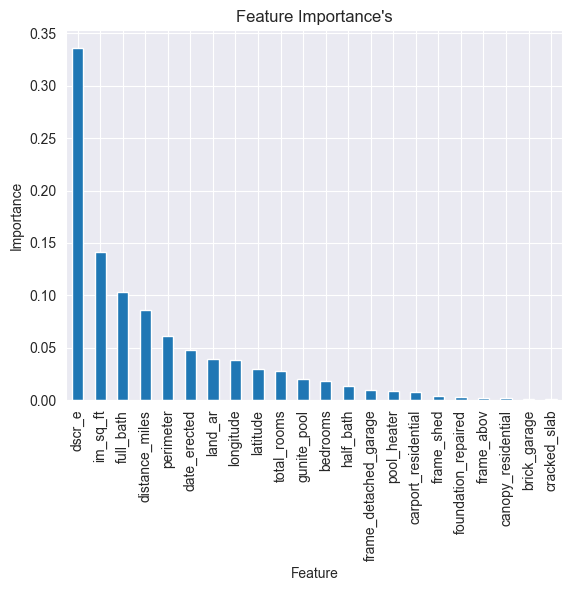

In [20]:
feature_names = [f"{i}" for i in X.columns]
best_model = etr_cv.best_estimator_
feature_importances = best_model.feature_importances_

# Rank the features by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Graph the importance of the features
importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title("Feature Importance's")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()


In [21]:
ert_cv_results = pd.DataFrame(etr_cv.cv_results_)
ert_cv_results["param_n_estimators"] = ert_cv_results["param_n_estimators"].astype(
    "category"
)
ert_cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.311836      0.082095         0.109884        0.065619   
1       1.175237      0.231370         0.130470        0.088310   
2      15.066446      0.199850         0.423300        0.153749   
3      14.735400      0.564045         0.394514        0.102016   
4      38.006497      0.261379         1.013051        0.101580   
5      37.637294      0.576474         0.926550        0.027769   
6      61.826595      0.595779         1.564227        0.146676   
7      61.831704      0.149593         1.503214        0.104983   
8      82.332741      1.615597         1.874583        0.150871   
9      71.312682      9.123852         1.441319        0.423636   

  param_criterion  param_max_features  param_min_samples_leaf  \
0    friedman_mse                  23                       1   
1    friedman_mse                  23                       1   
2    friedman_mse                  23                       1   
3    friedman_mse                  23                       1   
4    friedman_mse                  23                       1   
5    friedman_mse                  23                       1   
6    friedman_mse                  23                       1   
7    friedman_mse                  23                       1   
8    friedman_mse                  23                       1   
9    friedman_mse                  23                       1   

  param_n_estimators  param_warm_start  \
0                100              True   
1                100             False   
2               1000              True   
3               1000             False   
4               2500              True   
5               2500             False   
6               4000              True   
7               4000             False   
8               5000              True   
9               5000             False   

                                              params  split0_test_score  \
0  {'criterion': 'friedman_mse', 'max_features': ...           0.807454   
1  {'criterion': 'friedman_mse', 'max_features': ...           0.807454   
2  {'criterion': 'friedman_mse', 'max_features': ...           0.813861   
3  {'criterion': 'friedman_mse', 'max_features': ...           0.813861   
4  {'criterion': 'friedman_mse', 'max_features': ...           0.813945   
5  {'criterion': 'friedman_mse', 'max_features': ...           0.813945   
6  {'criterion': 'friedman_mse', 'max_features': ...           0.814468   
7  {'criterion': 'friedman_mse', 'max_features': ...           0.814468   
8  {'criterion': 'friedman_mse', 'max_features': ...           0.814655   
9  {'criterion': 'friedman_mse', 'max_features': ...           0.814655   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.844452           0.822009           0.823985           0.727900   
1           0.844452           0.822009           0.823985           0.727900   
2           0.844249           0.823007           0.827084           0.732077   
3           0.844249           0.823007           0.827084           0.732077   
4           0.843960           0.822699           0.827332           0.731943   
5           0.843960           0.822699           0.827332           0.731943   
6           0.845309           0.822343           0.828274           0.732105   
7           0.845309           0.822343           0.828274           0.732105   
8           0.845554           0.822136           0.827663           0.731957   
9           0.845554           0.822136           0.827663           0.731957   

   mean_test_score  std_test_score  rank_test_score  
0         0.805160        0.040389                9  
1         0.805160        0.040389                9  
2         0.808056        0.039248                5  
3         0.808056        0.039248                5  
4         0.807976        0.039250                7  
5         0.807976        0.039250          

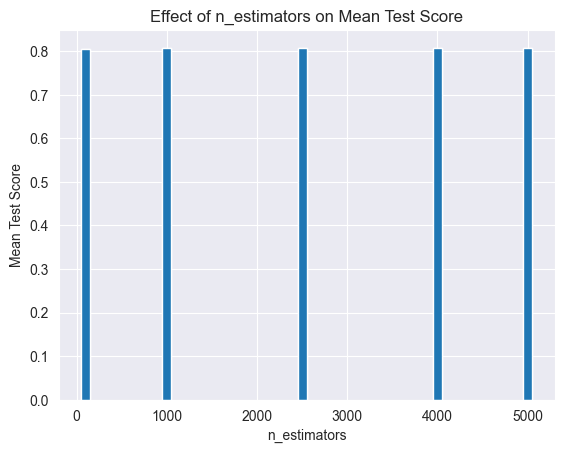

In [51]:
plt.bar(
    ert_cv_results["param_n_estimators"], ert_cv_results["mean_test_score"], width=100
)
plt.xlabel("n_estimators")
plt.ylabel("Mean Test Score")
plt.title("Effect of n_estimators on Mean Test Score")
plt.show()

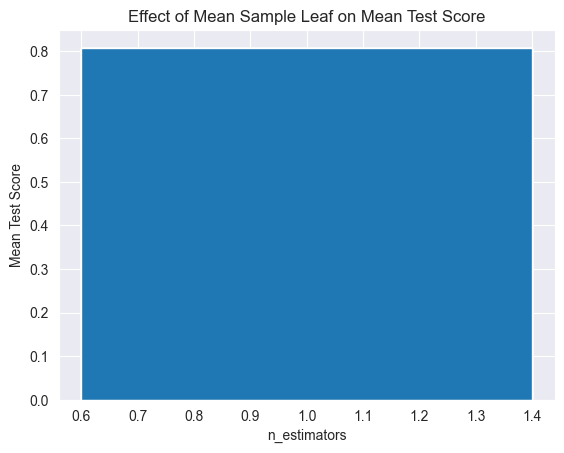

In [23]:
plt.bar(
    ert_cv_results["param_min_samples_leaf"],
    ert_cv_results["mean_test_score"],
    width=0.8,
)
plt.xlabel("n_estimators")
plt.ylabel("Mean Test Score")
plt.title("Effect of Mean Sample Leaf on Mean Test Score")
plt.show()

## Analysis of testing data

In [24]:
etc_pred = etr_cv.predict(x_test)
etc_mae = mean_absolute_error(y_test, etc_pred)
etc_mse = mean_squared_error(y_test, etc_pred)
etc_r2 = r2_score(y_test, etc_pred)
print(f"MAE: {etc_mae}\nMSE: {etc_mse}\nR Squared: {etc_r2}\n")

MAE: 51901.11728499999
MSE: 9824515222.927755
R Squared: 0.8706303674688454



In [25]:
# Define the folder name
folder_name = "Models"

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

# Get the current date
current_date = datetime.now()

# Format the date as YYYYmmdd
formatted_date = current_date.strftime("%Y%m%d")

joblib.dump(etr_cv, f"Models/etc_{formatted_date}.pkl")

Folder 'Models' already exists.


['Models/etc_20241127.pkl']

# Residual Analysis

In [26]:
actual = y_test.to_list()
predicted = etr_cv.predict(x_test)
etc_residuals = pd.DataFrame({"actual": actual, "predicted": predicted})
etc_residuals["residuals"] = etc_residuals["actual"] - etc_residuals["predicted"]

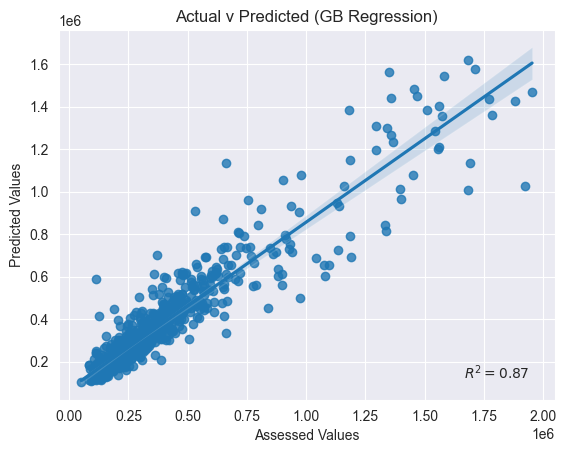

In [27]:
sns.regplot(etc_residuals, x="actual", y="predicted")
plt.xlabel('Assessed Values')
plt.ylabel('Predicted Values')
plt.title('Actual v Predicted (GB Regression)')

plt.text(0.95, 0.05, f"$R^2 = {etc_r2:.2f}$",
         horizontalalignment='right',
         verticalalignment='bottom',
         transform=plt.gca().transAxes,
         fontsize=10)
plt.show()

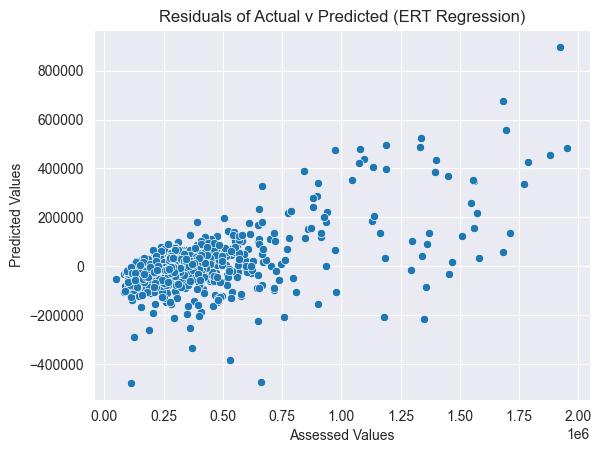

In [28]:
sns.scatterplot(etc_residuals, x="actual", y="residuals")
plt.xlabel('Assessed Values')
plt.ylabel('Predicted Values')
plt.title('Residuals of Actual v Predicted (ERT Regression)')
plt.show()

## Gradient Boosting Regression

Gradient boosting is another ensemble algorithm that can be used much like Extra Random Trees. It differs in the way that it makes the trees. In gradient boosting new trees are added to correct errors of the previous tress in a sequential manner, while extra random trees builds tress independently by randomly selecting features and split points at each node, which makes it less prone to overfitting compared to gradient boosting which can be more sensitive to overfitting.

In [29]:
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    "n_estimators": [3000, 4000],
    "learning_rate": [0.005, 0.0005],
    "max_depth": [5],
    "min_samples_split": [1, 3, 5, 7, 9],
    "min_samples_leaf": [1],
    "max_features": [(X.shape[1] + 1)],
    "warm_start": [True],
    "criterion": ["friedman_mse"],
}
gbr_cv = GridSearchCV(gbr, param_grid, cv=5, n_jobs=4, scoring="r2")

In [30]:
gbr_cv.fit(x_train, y_train)
gbr_pred = gbr_cv.predict(x_test)

C:\Users\Blake\PycharmProjects\HouseProtestValues\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Blake\PycharmProjects\HouseProtestValues\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Blake\PycharmProjects\HouseProtestValues\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Blake\PycharmProjects\HouseProtestValues\.venv\Lib\site-packages\sklearn\ba

In [31]:
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_r2 = r2_score(y_test, gbr_pred)
print(f"MAE: {gbr_mae}\nMSE: {gbr_mse}\nR Squared: {gbr_r2}\n")

MAE: 46840.17332970306
MSE: 7265569614.7734
R Squared: 0.9043266716103017



In [32]:
gbr_cv.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.005,
 'max_depth': 5,
 'max_features': 23,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 4000,
 'warm_start': True}

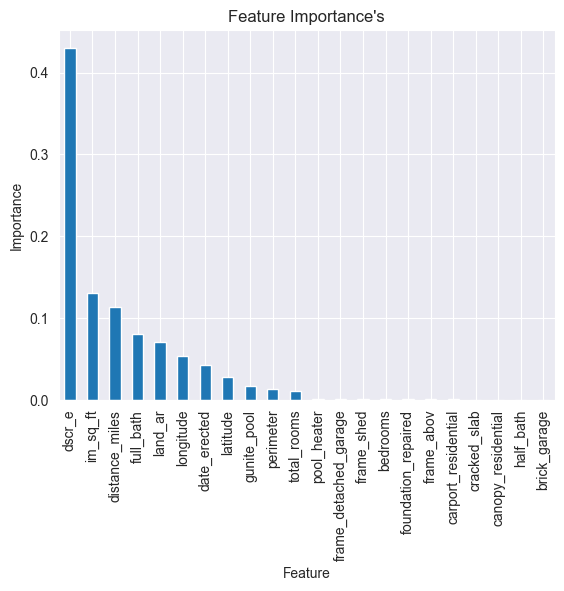

In [33]:
feature_names = [f"{i}" for i in X.columns]
best_model = gbr_cv.best_estimator_
feature_importances = best_model.feature_importances_

# Rank the features by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Graph the importance of the features
importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title("Feature Importance's")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

In [34]:
gbr_cv.best_score_

np.float64(0.8514401933340098)

In [35]:
joblib.dump(gbr_cv, "Models/gbr.pkl")

# load
# joblib.load('gbr.pkl')

['Models/gbr.pkl']

In [36]:
gbr_residual_df = pd.DataFrame(
    {
        "actual": actual,
        "predicted": gbr_pred,
    }
)
gbr_residual_df["residuals"] = gbr_residual_df["actual"] - gbr_residual_df["predicted"]

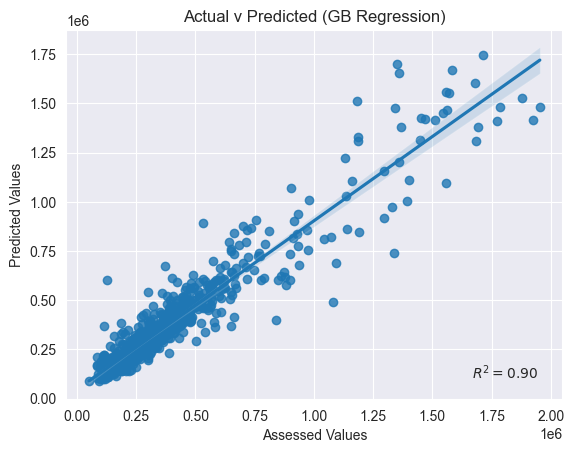

In [37]:
sns.regplot(gbr_residual_df, x="actual", y="predicted")
plt.xlabel('Assessed Values')
plt.ylabel('Predicted Values')
plt.title('Actual v Predicted (GB Regression)')

plt.text(0.95, 0.05, f"$R^2 = {gbr_r2:.2f}$",
         horizontalalignment='right',
         verticalalignment='bottom',
         transform=plt.gca().transAxes,
         fontsize=10)
plt.show()

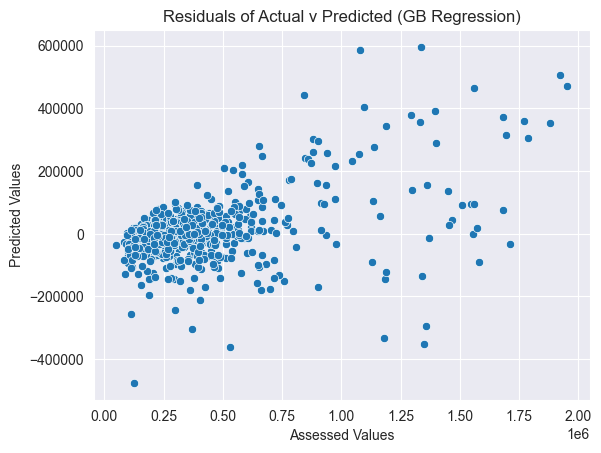

In [38]:
sns.scatterplot(gbr_residual_df, x="actual", y="residuals")
plt.xlabel('Assessed Values')
plt.ylabel('Predicted Values')
plt.title('Residuals of Actual v Predicted (GB Regression)')
plt.show()

# Apply model to entire dataset
The model was created with a random subset of the data to reduce the training time. This will apply the model to the rest of the dataset.

In [39]:
df

acct  bld_num  date_erected  im_sq_ft  land_ar  perimeter  \
0          20720000014        1          2019      2534     5564        452   
1          21440000001        1          2004      2537     5000        314   
2          21480000002        1          1917      1496     5000        186   
3          21650000007        1          2015      3387     5000        578   
4          21650000011        1          2003      1508     6250        210   
...                ...      ...           ...       ...      ...        ...   
1121037  1938003804013        1          2003      2117     5250        318   
1121038  1938003804014        1          2003      1611     5250        184   
1121039  1953050320690        1          1979      2168     6820        232   
1121040  1953080320060        1          1983      1723     7575        216   
1121041  1955020050280        1          1979      1374     8851        250   

        dpr_val  bedrooms  full_bath  half_bath  ...  cracked_slab   latitude  \
0        483261       3.0        3.0        1.0  ...             0  29.743903   
1        307658       3.0        2.0        1.0  ...             0  29.740005   
2          9621       3.0        1.0        0.0  ...             0  29.742185   
3        587261       3.0        3.0        1.0  ...             0  29.741158   
4        172034       3.0        2.0        0.0  ...             0  29.741294   
...         ...       ...        ...        ...  ...           ...        ...   
1121037  235142       3.0        2.0        1.0  ...             0  29.594555   
1121038  205392       3.0        2.0        0.0  ...             0  29.594558   
1121039  201010       3.0        2.0        0.0  ...             0  29.694444   
1121040  181811       3.0        2.0        0.0  ...             0  29.694102   
1121041  160896       3.0        2.0        1.0  ...             0  29.702614   

         longitude  land_val   bld_val  assessed_val  tot_appr_val  \
0       -95.356534  253352.0  451951.0      705303.0      705303.0   
1       -95.358428  200000.0  307658.0      510178.0      311246.0   
2       -95.361765  200000.0    9486.0      209586.0      209586.0   
3       -95.361889  200000.0  523919.0      723919.0      723919.0   
4       -95.361493  225000.0  172034.0      397034.0      388778.0   
...            ...       ...       ...           ...           ...   
1121037 -95.453635   35438.0  233603.0      269041.0      269041.0   
1121038 -95.453478   35438.0  204053.0      239491.0      166883.0   
1121039 -95.658936   54560.0  201010.0      255570.0      240372.0   
1121040 -95.658271   55740.0  173156.0      228896.0      228896.0   
1121041 -95.673357   64580.0  160896.0      225476.0      216585.0   

         tot_mkt_val  assessed_per_sqft  distance_miles  
0           705303.0         278.335833        1.383701  
1           510178.0         201.094994        1.554979  
2           209586.0         140.097594        1.334974  
3           723919.0         213.734573        1.398421  
4           397034.0         263.285146        1.398188  
...              ...                ...             ...  
1121037     269041.0         127.085971       12.489168  
1121038     239491.0         148.659839       12.485174  
1121039     255570.0         117.882841       17.914352  
1121040     228896.0         132.847359       17.881794  
1121041     225476.0         164.101892       18.623451  

[1103546 rows x 32 columns]

In [40]:
X = df[
    [
        "date_erected",
        "im_sq_ft",
        "land_ar",
        "perimeter",
        "bedrooms",
        "full_bath",
        "half_bath",
        "total_rooms",
        "latitude",
        "longitude",
        "dscr_e",
        "frame_detached_garage",
        "gunite_pool",
        "pool_heater",
        "brick_garage",
        "canopy_residential",
        "frame_abov",
        "frame_shed",
        "carport_residential",
        "foundation_repaired",
        "cracked_slab",
        "distance_miles",
    ]
]
df['ert_predicted'] = etr_cv.predict(X)
df['gbr_predicted'] = gbr_cv.predict(X)

In [41]:
df[['assessed_val', 'ert_predicted', 'gbr_predicted']]

assessed_val  ert_predicted  gbr_predicted
0            705303.0   725933.80800  634838.471974
1            510178.0   676268.52000  424861.863692
2            209586.0   315696.83825  296759.491263
3            723919.0   737032.67825  749957.402051
4            397034.0   321819.47075  333233.034124
...               ...            ...            ...
1121037      269041.0   279757.11575  260890.452940
1121038      239491.0   226513.52325  223886.588798
1121039      255570.0   262377.14925  256913.813718
1121040      228896.0   241501.40975  231122.271429
1121041      225476.0   216230.19550  206964.149056

[1103546 rows x 3 columns]

# Merge Mailing Address
Merge the Mailing Address information with the properties to protest

In [59]:
# Get mailing address
con = sqlite3.connect("HouseProtestValues.db")
sql_address = """SELECT acct,
                        mailto,
                        mail_addr_1,
                        mail_addr_2,
                        Mail_city,
                        mail_state,
                        mail_zip
                FROM real_acct;"""
mail_addr = pd.read_sql_query(sql_address, con)

df = df.merge(mail_addr, left_on='acct', right_on='acct')
df

acct  bld_num  date_erected  im_sq_ft  land_ar  perimeter  \
0          20720000014        1          2019      2534     5564        452   
1          21440000001        1          2004      2537     5000        314   
2          21480000002        1          1917      1496     5000        186   
3          21650000007        1          2015      3387     5000        578   
4          21650000011        1          2003      1508     6250        210   
...                ...      ...           ...       ...      ...        ...   
1103541  1938003804013        1          2003      2117     5250        318   
1103542  1938003804014        1          2003      1611     5250        184   
1103543  1953050320690        1          1979      2168     6820        232   
1103544  1953080320060        1          1983      1723     7575        216   
1103545  1955020050280        1          1979      1374     8851        250   

        dpr_val  bedrooms  full_bath  half_bath  ...  assessed_per_sqft  \
0        483261       3.0        3.0        1.0  ...         278.335833   
1        307658       3.0        2.0        1.0  ...         201.094994   
2          9621       3.0        1.0        0.0  ...         140.097594   
3        587261       3.0        3.0        1.0  ...         213.734573   
4        172034       3.0        2.0        0.0  ...         263.285146   
...         ...       ...        ...        ...  ...                ...   
1103541  235142       3.0        2.0        1.0  ...         127.085971   
1103542  205392       3.0        2.0        0.0  ...         148.659839   
1103543  201010       3.0        2.0        0.0  ...         117.882841   
1103544  181811       3.0        2.0        0.0  ...         132.847359   
1103545  160896       3.0        2.0        1.0  ...         164.101892   

         distance_miles  ert_predicted  gbr_predicted  \
0              1.383701   725933.80800  634838.471974   
1              1.554979   676268.52000  424861.863692   
2              1.334974   315696.83825  296759.491263   
3              1.398421   737032.67825  749957.402051   
4              1.398188   321819.47075  333233.034124   
...                 ...            ...            ...   
1103541       12.489168   279757.11575  260890.452940   
1103542       12.485174   226513.52325  223886.588798   
1103543       17.914352   262377.14925  256913.813718   
1103544       17.881794   241501.40975  231122.271429   
1103545       18.623451   216230.19550  206964.149056   

                                                 mailto  \
0                                        CANALES GIL JR   
1                              TREWICK MICHAEL & MEGONE   
2                           SMITH SAMPSON AND BEENE LLC   
3                                        SUAREZ JORGE A   
4                                  BROOKS LONNIE & LISA   
...                                                 ...   
1103541                               HERNANDEZ ALFREDO   
1103542                                   REYES EULALIA   
1103543                       CARRENS JAY 1953050320690   
1103544  SFR-HOU I LLC V KHEMKA & UMA V KHEMKA TRUSTEES   
1103545                                    MONGE OLGA Y   

                      mail_addr_1  mail_addr_2  mail_city  mail_state  \
0        2825 WILCREST DR STE 669                 HOUSTON          TX   
1                2120 LIVE OAK ST                 HOUSTON          TX   
2        440 LOUISIANA ST STE 900                 HOUSTON          TX   
3                2217 HUTCHINS ST                 HOUSTON          TX   
4                 2212 WEBSTER ST                 HOUSTON          TX   
...                           ...          ...        ...         ...   
1103541           16510 DETRIC LN                 HOUSTON          TX   
1103542      4835 BRYANT RIDGE RD                 HOUSTON          TX   
1103543         7307 EL CRESTA DR                 HOUSTON          TX   
1103544               PO BOX 2249           

# Properties that should be protested

In [60]:
protest_ert = df.query('assessed_val <= ert_predicted')
protest_gbr = df.query('assessed_val <= gbr_predicted')

In [61]:
total = df.shape[0]
count_ert = protest_ert.shape[0]
count_gbr = protest_gbr.shape[0]
print(f"Total Accounts: {total}, Extra Trees: {count_ert}, Gradient Boosting Regressor: {count_gbr}")

Total Accounts: 1103546, Extra Trees: 613382, Gradient Boosting Regressor: 570179


In [62]:
# Define the folder name
folder_name = "Output"

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")


def output_dataframe_csv(df_name, name):
    df_name.to_csv(f"Output/{name}.csv", index=False)


Folder 'Output' already exists.


In [63]:
output_dataframe_csv(df, "All_Data")
output_dataframe_csv(protest_ert, "Protest_Data_Extra_Trees")
output_dataframe_csv(protest_gbr, "Protest_Data_Extra_GBR")

## Proportions of homes to be send advertiments

In [65]:
percent_etr = (count_ert / total) * 100
percent_gbr = (count_gbr / total) * 100
print(
    f"Extra Random Trees regression model predicts that {percent_etr:.2f}% of total accounts should be protested.\nGradient Boosting Regressor: {percent_gbr:.2f}% of total accounts.")

Extra Random Trees regression model predicts that 55.58% of total accounts should be protested.
Gradient Boosting Regressor: 51.67% of total accounts.
